# Phase 5 - Protein Language Model Classification

## Goal
- Train ESM-2 embeddings classifier on **labeled sequences**
- Predict subfamily classes for **unlabeled sequences** (without UniRef IDs)

## Key Fixes
- ✅ Use **full-length sequences** (not C-terminal tails)
- ✅ Apply **class balancing** to handle imbalanced data
- ✅ Train/test on labeled data, predict unlabeled data

---
## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

# Check if torch is installed
try:
    import torch
    print(f"PyTorch installed: {torch.__version__}")
    print(f"CUDA available: {torch.cuda.is_available()}")
except ImportError:
    print("PyTorch not installed")
    print("Install: pip install torch")

pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("\n✓ Libraries imported")

PyTorch installed: 2.10.0+cpu
CUDA available: False

✓ Libraries imported


---
## 2. Install ESM-2 (if needed)

In [2]:
# Install ESM if not already installed
try:
    import esm
    print("✓ ESM already installed")
except ImportError:
    print("Installing ESM-2...")
    !pip install fair-esm
    import esm
    print("✓ ESM installed")

✓ ESM already installed


---
## 3. Load Data - CORRECTED ✅

**Key Change:** Using full-length sequences instead of C-terminal tails

In [10]:
print("="*80)
print("LOADING DATA")
print("="*80)

# Load FULL sequences with subfamily labels (for training)
df_labeled = pd.read_csv('../data/processed/sequences_labeled_full.csv')

print(f"\n✓ Total labeled sequences: {len(df_labeled)}")
print(f"\nSubfamily distribution:")
print(df_labeled['subfamily'].value_counts())

# Load all sequences to find unlabeled ones (for prediction)
df_all = pd.read_csv('../data/processed/sequences_parsed.csv')
df_unlabeled = df_labeled.drop(columns=['subfamily'])
print(f"\n✓ Unlabeled sequences (to predict): {len(df_unlabeled)}")

# Check sequence lengths
print(f"\nSequence length statistics (labeled):")
print(df_labeled['sequence'].str.len().describe())

LOADING DATA

✓ Total labeled sequences: 1998

Subfamily distribution:
subfamily
Other_ClassA        1483
Adrenergic_beta      372
Adrenergic_alpha      53
Dopamine              35
Histamine             31
Serotonin             23
Muscarinic             1
Name: count, dtype: int64

✓ Unlabeled sequences (to predict): 1998

Sequence length statistics (labeled):
count    1998.000000
mean      431.241241
std        20.316989
min       413.000000
25%       416.000000
50%       424.000000
75%       439.000000
max       555.000000
Name: sequence, dtype: float64


### Optional: Sample for Testing

**Remove this cell for full dataset**

In [11]:
print("⚠️  Sampling 100 sequences per subfamily for faster testing")
print("Remove this cell for full dataset\n")

sampled_groups = []
for subfamily, group in df_labeled.groupby('subfamily'):
    n_sample = min(100, len(group))
    sampled = group.sample(n=n_sample, random_state=42)
    sampled_groups.append(sampled)

df_labeled_sampled = pd.concat(sampled_groups, ignore_index=True)

print(f"Working with {len(df_labeled_sampled)} labeled sequences")
print(df_labeled_sampled['subfamily'].value_counts())

⚠️  Sampling 100 sequences per subfamily for faster testing
Remove this cell for full dataset

Working with 343 labeled sequences
subfamily
Adrenergic_beta     100
Other_ClassA        100
Adrenergic_alpha     53
Dopamine             35
Histamine            31
Serotonin            23
Muscarinic            1
Name: count, dtype: int64


---
## 4. Load ESM-2 Model

Using **ESM-2 650M** - Good balance of performance and speed

In [12]:
print("="*80)
print("LOADING ESM-2 MODEL")
print("="*80)

import torch
import esm

print("\nLoading ESM-2 650M...")
print("First time will download ~2.5 GB\n")

model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()
batch_converter = alphabet.get_batch_converter()
model.eval()  # Disable dropout for inference

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print(f"✓ Model loaded")
print(f"Device: {device}")
print(f"Embedding dimension: {model.embed_dim}")
print(f"Number of layers: {model.num_layers}")

LOADING ESM-2 MODEL

Loading ESM-2 650M...
First time will download ~2.5 GB

✓ Model loaded
Device: cpu
Embedding dimension: 1280
Number of layers: 33


---
## 5. Define Embedding Function

In [13]:
def get_embedding(sequence, model, batch_converter, device):
    """
    Generate embedding for a single protein sequence using ESM-2
    
    Args:
        sequence: Protein sequence string
        model: ESM-2 model
        batch_converter: ESM batch converter
        device: torch device (cuda/cpu)
    
    Returns:
        numpy array of embeddings
    """
    # Prepare data
    data = [("protein", sequence)]
    batch_labels, batch_strs, batch_tokens = batch_converter(data)
    batch_tokens = batch_tokens.to(device)
    
    # Get embeddings from last layer
    with torch.no_grad():
        results = model(batch_tokens, repr_layers=[33])  # Layer 33 = last layer
        embeddings = results["representations"][33]
    
    # Mean pooling (excluding start/end tokens)
    embedding = embeddings[0, 1:-1].mean(dim=0)
    
    return embedding.cpu().numpy()

print("✓ Embedding function defined")

✓ Embedding function defined


---
## 6. Generate Embeddings for LABELED Data (Training)

This will take a few minutes...

In [14]:
print("="*80)
print("GENERATING EMBEDDINGS - LABELED DATA")
print("="*80)

print(f"\nProcessing {len(df_labeled_sampled)} sequences...")
print("This may take a few minutes\n")

embeddings_labeled = []
failed = 0
valid_indices = []

for idx, row in df_labeled_sampled.iterrows():
    try:
        # Use FULL sequence (truncate if too long)
        seq = row['sequence'][:1022]  # ESM-2 max is 1024 (including special tokens)
        
        # Skip if sequence too short
        if len(seq) < 10:
            raise ValueError("Sequence too short")
        
        embedding = get_embedding(seq, model, batch_converter, device)
        embeddings_labeled.append(embedding)
        valid_indices.append(idx)
        
        if (len(embeddings_labeled)) % 20 == 0:
            print(f"Processed {len(embeddings_labeled)}/{len(df_labeled_sampled)} sequences")
    
    except Exception as e:
        failed += 1
        if failed <= 5:  # Only show first 5 errors
            print(f"⚠️  Failed for sequence {idx}: {str(e)[:50]}")

# Convert to array
embeddings_labeled_array = np.array(embeddings_labeled)

# Filter dataframe to only valid sequences
df_labeled_valid = df_labeled_sampled.loc[valid_indices].reset_index(drop=True)

print(f"\n✓ Generated embeddings for labeled data")
print(f"Shape: {embeddings_labeled_array.shape}")
print(f"Valid: {len(embeddings_labeled)}/{len(df_labeled_sampled)}")
print(f"Failed: {failed}")

# Add embeddings to dataframe
df_labeled_valid['embedding'] = list(embeddings_labeled_array)

GENERATING EMBEDDINGS - LABELED DATA

Processing 343 sequences...
This may take a few minutes

⚠️  Failed for sequence 0: 'teksdservil'
⚠️  Failed for sequence 1: 'vdgvategvml'
⚠️  Failed for sequence 2: 'pktagasparplgrtrdtvaeapgrvvla'
⚠️  Failed for sequence 3: 'glregh'
⚠️  Failed for sequence 4: 'egegvtlrihrgn'
Processed 20/343 sequences

✓ Generated embeddings for labeled data
Shape: (33, 1280)
Valid: 33/343
Failed: 310


---
## 7. Train Classifier with Class Balancing ✅

In [15]:
print("="*80)
print("TRAINING CLASSIFIER")
print("="*80)

# Prepare data
X = embeddings_labeled_array
y = df_labeled_valid['subfamily'].values

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

print(f"\nFeatures: {X.shape}")
print(f"Labels: {y.shape}")
print(f"Classes: {le.classes_}")

# Check class distribution
unique, counts = np.unique(y_encoded, return_counts=True)
print(f"\nClass distribution:")
for cls, count in zip(le.classes_, counts):
    print(f"  {cls}: {count}")

# Split data (stratified to maintain class distribution)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_encoded
)

print(f"\nTrain: {len(X_train)} | Test: {len(X_test)}")

# Train Random Forest with CLASS BALANCING
print("\n✓ Training Random Forest with class balancing...")
rf_clf = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced',  # 🔥 IMPORTANT: Balance classes!
    max_depth=20
)
rf_clf.fit(X_train, y_train)

# Evaluate
y_pred = rf_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"\n✓ Training complete")
print(f"Test Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

TRAINING CLASSIFIER

Features: (33, 1280)
Labels: (33,)
Classes: ['Adrenergic_beta' 'Other_ClassA']

Class distribution:
  Adrenergic_beta: 28
  Other_ClassA: 5

Train: 26 | Test: 7

✓ Training Random Forest with class balancing...

✓ Training complete
Test Accuracy: 0.8571 (85.71%)


---
## 8. Evaluate Performance

CLASSIFICATION REPORT

                 precision    recall  f1-score   support

Adrenergic_beta       0.86      1.00      0.92         6
   Other_ClassA       0.00      0.00      0.00         1

       accuracy                           0.86         7
      macro avg       0.43      0.50      0.46         7
   weighted avg       0.73      0.86      0.79         7



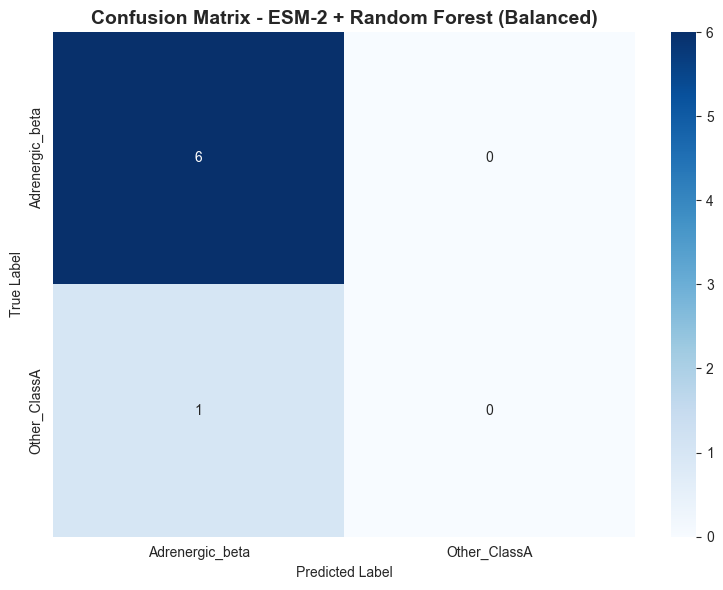


✓ Saved: ../results/figures/phase5_confusion_matrix_corrected.png


In [16]:
print("="*80)
print("CLASSIFICATION REPORT")
print("="*80)
print()

# Detailed report
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix - ESM-2 + Random Forest (Balanced)', 
          fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()

# Save
import os
os.makedirs('../results/figures', exist_ok=True)
plt.savefig('../results/figures/phase5_confusion_matrix_corrected.png', 
            dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Saved: ../results/figures/phase5_confusion_matrix_corrected.png")

---
## 9. Generate Embeddings for UNLABELED Data

In [ ]:
print("="*80)
print("GENERATING EMBEDDINGS - UNLABELED DATA")
print("="*80)

print(f"\nProcessing {len(df_unlabeled)} unlabeled sequences...")
print("This may take a while\n")

embeddings_unlabeled = []
failed_unlabeled = 0
valid_unlabeled_indices = []

for idx, row in df_unlabeled.iterrows():
    try:
        seq = row['sequence'][:1022]
        
        if len(seq) < 10:
            raise ValueError("Sequence too short")
        
        embedding = get_embedding(seq, model, batch_converter, device)
        embeddings_unlabeled.append(embedding)
        valid_unlabeled_indices.append(idx)
        
        if len(embeddings_unlabeled) % 20 == 0:
            print(f"Processed {len(embeddings_unlabeled)}/{len(df_unlabeled)} sequences")
    
    except Exception as e:
        failed_unlabeled += 1
        if failed_unlabeled <= 5:
            print(f"⚠️  Failed for sequence {idx}: {str(e)[:50]}")

embeddings_unlabeled_array = np.array(embeddings_unlabeled)

# Filter to valid sequences
df_unlabeled_valid = df_unlabeled.loc[valid_unlabeled_indices].reset_index(drop=True)

print(f"\n✓ Generated embeddings for unlabeled data")
print(f"Shape: {embeddings_unlabeled_array.shape}")
print(f"Valid: {len(embeddings_unlabeled)}/{len(df_unlabeled)}")
print(f"Failed: {failed_unlabeled}")

GENERATING EMBEDDINGS - UNLABELED DATA

Processing 1998 unlabeled sequences...
This may take a while

⚠️  Failed for sequence 1: 'sey'
⚠️  Failed for sequence 2: 'gktdy'
⚠️  Failed for sequence 3: 'gh'
⚠️  Failed for sequence 4: 'ksdya'
⚠️  Failed for sequence 5: 'gktey'
Processed 20/1998 sequences
Processed 40/1998 sequences


---
## 10. PREDICT Classes for Unknown Sequences 🎯

In [ ]:
print("="*80)
print("PREDICTING UNKNOWN SEQUENCES")
print("="*80)

# Get predictions
y_pred_unlabeled = rf_clf.predict(embeddings_unlabeled_array)
y_pred_proba = rf_clf.predict_proba(embeddings_unlabeled_array)

# Convert back to subfamily names
predicted_subfamilies = le.inverse_transform(y_pred_unlabeled)

# Add predictions to dataframe
df_unlabeled_valid['predicted_subfamily'] = predicted_subfamilies
df_unlabeled_valid['prediction_confidence'] = y_pred_proba.max(axis=1)

# Add individual class probabilities
for i, class_name in enumerate(le.classes_):
    df_unlabeled_valid[f'prob_{class_name}'] = y_pred_proba[:, i]

print(f"\n✓ Predictions complete for {len(df_unlabeled_valid)} sequences")
print(f"\nPredicted distribution:")
print(df_unlabeled_valid['predicted_subfamily'].value_counts())

print(f"\nConfidence statistics:")
print(f"  Mean: {df_unlabeled_valid['prediction_confidence'].mean():.3f}")
print(f"  Min:  {df_unlabeled_valid['prediction_confidence'].min():.3f}")
print(f"  Max:  {df_unlabeled_valid['prediction_confidence'].max():.3f}")

---
## 11. Visualize Prediction Confidence

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confidence distribution
axes[0].hist(df_unlabeled_valid['prediction_confidence'], bins=30, edgecolor='black')
axes[0].set_xlabel('Prediction Confidence', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Distribution of Prediction Confidence', fontsize=13, fontweight='bold')
axes[0].axvline(df_unlabeled_valid['prediction_confidence'].mean(), 
                color='red', linestyle='--', label='Mean')
axes[0].legend()

# Predicted classes
pred_counts = df_unlabeled_valid['predicted_subfamily'].value_counts()
axes[1].bar(range(len(pred_counts)), pred_counts.values, edgecolor='black')
axes[1].set_xticks(range(len(pred_counts)))
axes[1].set_xticklabels(pred_counts.index, rotation=45, ha='right')
axes[1].set_xlabel('Predicted Subfamily', fontsize=12)
axes[1].set_ylabel('Count', fontsize=12)
axes[1].set_title('Predicted Class Distribution', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.savefig('../results/figures/phase5_prediction_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: ../results/figures/phase5_prediction_analysis.png")

---
## 12. Show Sample Predictions

In [ ]:
print("="*80)
print("SAMPLE PREDICTIONS (Top 20)")
print("="*80)

# Select columns to display
display_cols = ['sequence_id', 'predicted_subfamily', 'prediction_confidence']

# Add probability columns if they exist
prob_cols = [col for col in df_unlabeled_valid.columns if col.startswith('prob_')]
if prob_cols:
    display_cols.extend(prob_cols[:3])  # Show first 3 probability columns

sample_predictions = df_unlabeled_valid[display_cols].head(20)
print(sample_predictions.to_string(index=False))

# Show high confidence predictions
print("\n" + "="*80)
print("HIGH CONFIDENCE PREDICTIONS (>0.9)")
print("="*80)
high_conf = df_unlabeled_valid[df_unlabeled_valid['prediction_confidence'] > 0.9]
print(f"\nFound {len(high_conf)} high-confidence predictions")
if len(high_conf) > 0:
    print(high_conf[display_cols].head(10).to_string(index=False))

---
## 13. Save All Results

In [ ]:
print("="*80)
print("SAVING RESULTS")
print("="*80)

import os
import joblib
import json

# Create directories
os.makedirs('../results', exist_ok=True)
os.makedirs('../models', exist_ok=True)
os.makedirs('../data/processed', exist_ok=True)

# 1. Save predictions
df_unlabeled_valid.to_csv('../results/predicted_sequences.csv', index=False)
print("✓ Saved: ../results/predicted_sequences.csv")

# 2. Save model and label encoder
joblib.dump(rf_clf, '../models/phase5_random_forest_corrected.pkl')
joblib.dump(le, '../models/phase5_label_encoder.pkl')
print("✓ Saved: ../models/phase5_random_forest_corrected.pkl")
print("✓ Saved: ../models/phase5_label_encoder.pkl")

# 3. Save embeddings
np.save('../data/processed/phase5_embeddings_labeled.npy', embeddings_labeled_array)
np.save('../data/processed/phase5_embeddings_unlabeled.npy', embeddings_unlabeled_array)
print("✓ Saved: embeddings (.npy files)")

# 4. Save results summary
results_summary = {
    'model': 'ESM-2 650M + Random Forest (Balanced)',
    'n_labeled_total': len(df_labeled),
    'n_labeled_used': len(df_labeled_valid),
    'n_unlabeled_total': len(df_unlabeled),
    'n_unlabeled_predicted': len(df_unlabeled_valid),
    'n_train': len(X_train),
    'n_test': len(X_test),
    'test_accuracy': float(accuracy),
    'embedding_dim': int(model.embed_dim),
    'classes': le.classes_.tolist(),
    'prediction_confidence_mean': float(df_unlabeled_valid['prediction_confidence'].mean()),
    'prediction_confidence_std': float(df_unlabeled_valid['prediction_confidence'].std()),
    'predicted_distribution': df_unlabeled_valid['predicted_subfamily'].value_counts().to_dict()
}

with open('../results/phase5_results_corrected.json', 'w') as f:
    json.dump(results_summary, f, indent=2)
print("✓ Saved: ../results/phase5_results_corrected.json")

print("\n" + "="*80)
print("✅ PHASE 5 COMPLETE!")
print("="*80)
print(f"\n📊 Training Results:")
print(f"   • Trained on: {len(X_train)} sequences")
print(f"   • Test accuracy: {accuracy*100:.2f}%")
print(f"\n🎯 Prediction Results:")
print(f"   • Predicted: {len(df_unlabeled_valid)} sequences")
print(f"   • Avg confidence: {df_unlabeled_valid['prediction_confidence'].mean():.3f}")
print(f"\n📁 Output Files:")
print(f"   • Predictions: ../results/predicted_sequences.csv")
print(f"   • Model: ../models/phase5_random_forest_corrected.pkl")
print(f"   • Summary: ../results/phase5_results_corrected.json")

---
## 14. Optional: t-SNE Visualization

In [ ]:
from sklearn.manifold import TSNE

print("="*80)
print("VISUALIZING EMBEDDINGS (t-SNE)")
print("="*80)

print("\nRunning t-SNE (this may take a minute)...")

# Run t-SNE on labeled data
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embeddings_2d = tsne.fit_transform(X)

# Plot
plt.figure(figsize=(12, 8))

for i, subfamily in enumerate(le.classes_):
    mask = (y == subfamily)
    plt.scatter(embeddings_2d[mask, 0], embeddings_2d[mask, 1],
                label=subfamily, alpha=0.6, s=50)

plt.xlabel('t-SNE Dimension 1', fontsize=12)
plt.ylabel('t-SNE Dimension 2', fontsize=12)
plt.title('ESM-2 Embeddings Visualization (t-SNE projection)',
          fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.savefig('../results/figures/phase5_tsne_corrected.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Saved: ../results/figures/phase5_tsne_corrected.png")